In [3]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping

In [69]:
# Load historical stock data (Apple Inc.)
data = yf.download('TSLA', start='2015-01-01', end='2024-10-08')
prices = data['Close'].values

[*********************100%***********************]  1 of 1 completed


In [70]:
# Scale the prices between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
prices_scaled = scaler.fit_transform(prices.reshape(-1, 1))

In [71]:
# Create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)
seq_length = 30
X, y = create_sequences(prices_scaled, seq_length)

In [72]:
# Split data into train/test sets (80% train, 20% test)
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [73]:
# Build the CNN model
model = Sequential()
model.add(Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(seq_length, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))  # Output layer

/Users/calebhan/Documents/Coding/Personal/portfolio_optimization/venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [74]:
# Compile the model
model.compile(optimizer='adam', loss='mse')

In [75]:
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

In [76]:
# Train the model
model.fit(X_train, y_train, epochs=250, batch_size=64, validation_data=(X_test, y_test), 
          callbacks=[early_stopping], verbose=2)

Epoch 1/250
31/31 - 0s - 15ms/step - loss: 0.0123 - val_loss: 0.0058
Epoch 2/250
31/31 - 0s - 2ms/step - loss: 0.0025 - val_loss: 0.0045
Epoch 3/250
31/31 - 0s - 2ms/step - loss: 0.0020 - val_loss: 0.0047
Epoch 4/250
31/31 - 0s - 2ms/step - loss: 0.0019 - val_loss: 0.0037
Epoch 5/250
31/31 - 0s - 2ms/step - loss: 0.0016 - val_loss: 0.0049
Epoch 6/250
31/31 - 0s - 2ms/step - loss: 0.0015 - val_loss: 0.0029
Epoch 7/250
31/31 - 0s - 2ms/step - loss: 0.0014 - val_loss: 0.0027
Epoch 8/250
31/31 - 0s - 2ms/step - loss: 0.0014 - val_loss: 0.0030
Epoch 9/250
31/31 - 0s - 2ms/step - loss: 0.0012 - val_loss: 0.0030
Epoch 10/250
31/31 - 0s - 2ms/step - loss: 0.0012 - val_loss: 0.0040
Epoch 11/250
31/31 - 0s - 2ms/step - loss: 0.0013 - val_loss: 0.0020
Epoch 12/250
31/31 - 0s - 2ms/step - loss: 0.0012 - val_loss: 0.0022
Epoch 13/250
31/31 - 0s - 2ms/step - loss: 9.9130e-04 - val_loss: 0.0021
Epoch 14/250
31/31 - 0s - 2ms/step - loss: 0.0011 - val_loss: 0.0018
Epoch 15/250
31/31 - 0s - 2ms/step - l

In [77]:
# Make predictions
y_pred = model.predict(X_test)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [78]:
# Inverse transform predictions to original scale
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

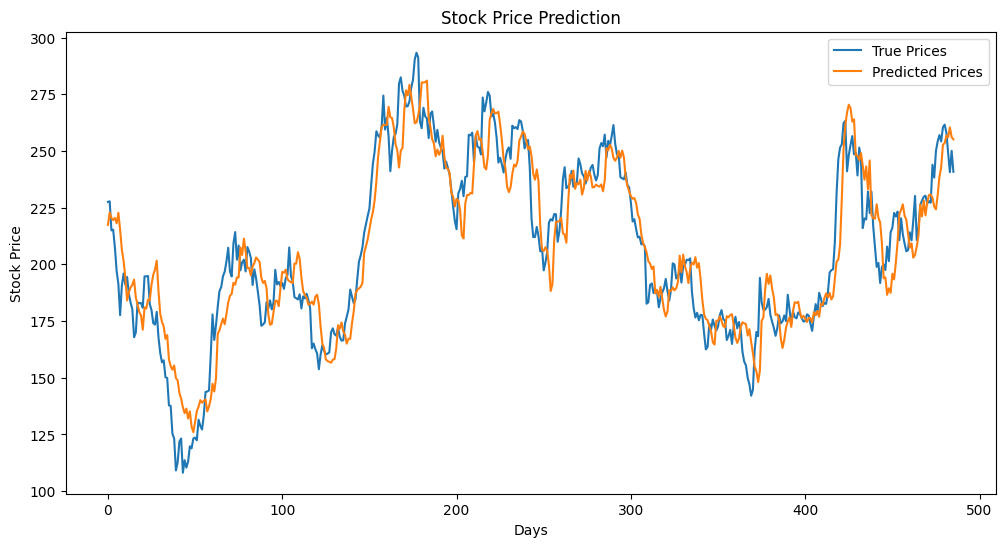

In [79]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test)), y_test, label='True Prices')
plt.plot(range(len(y_pred)), y_pred, label='Predicted Prices')
plt.legend()
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction')
plt.show()